In [1]:
import numpy as np
import pandas as pd

import scipy

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()



In [2]:
df = pd.read_csv('data/people_data_clustering.csv', index_col=0)
print('Размеры',df.shape)
df.head()

Размеры (6000, 9)


,id,was_married,childrens,salary,sex,age,profession,home_cost,drive_info
0,0,1,4.0,45032.40,1,82.0,Engineer,1.003674e+07,NaN
1,1,1,2.0,202004.64,1,32.0,Doctor,1.014051e+07,0.0
2,2,1,6.0,213158.75,1,14.0,Entertainment,1.043318e+07,NaN
3,3,0,1.0,185692.78,0,10.0,Lawyer,1.004299e+07,NaN
4,4,1,9.0,132067.32,1,99.0,Artist,1.021908e+07,NaN


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `childrens` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол
* `age` - Возраст
* `home_cost` - Стоимость жилья
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет и, используя класстерный анализ, разбить пользователей на сегменты. Сделать выводы о причинах такой кластеризации.

# Изучение датасета (5 баллов)
* Какие признаки численные?
* Какие признаки категориальные?
* Какие признаки бинарные?
* Какие признаки имеют нормальное распределение?
* Какие признаки бессмысленные?

# Ответы:

<b>Численные признаки:</b>

Дискретные: children, age

Непрерывные: salary, home_cost

In [3]:
numerical = df.select_dtypes(include=[np.number]).columns.values

for sign in numerical:
    print(f'{sign}: type = {df[sign].dtype}, count = {len(df[sign].unique())}')

# was_married, drive_info, sex хоть и появляются здесь, все же относятся к категориальным

id: type = int64, count = 5500
was_married: type = int64, count = 2
childrens: type = float64, count = 7
salary: type = float64, count = 5143
sex: type = int64, count = 2
age: type = float64, count = 20
home_cost: type = float64, count = 5500
drive_info: type = float64, count = 3


<b>Категориальные:</b>

Их них три - was_married, drive_info, sex так же относятся к бинарным

In [4]:
# df.select_dtypes(exclude=[np.number]).columns.values
categorical = ('profession', 'sex', 'was_married', 'drive_info')
for sign in categorical:
    print(f'{sign}: type = {df[sign].dtype}')


profession: type = object
sex: type = int64
was_married: type = int64
drive_info: type = float64


<b>Бинарные:</b>

Для идентификации этого признака, выведем кол-во уникальных значений (должно быть 2), удалив перед этим NaN


In [5]:
binary = ('was_married', 'sex', 'drive_info')

for sign in binary:
    print(f'{sign}: count = {len(df[sign].dropna().unique())}')

was_married: count = 2
sex: count = 2
drive_info: count = 2


<b>Бессмысленные:<b/>

Он один - id. Ненужный для обработки данных признак

In [6]:
useless = ('id',)
print(df.shape[0] == len(df[useless[0]]))

True


<b>Нормальное распределение</b>
Чтобы понять, какие признаки имеют нормальное распределение, следует построить график по значениям признаков

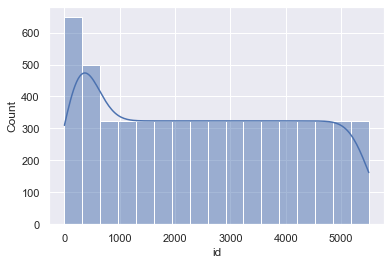

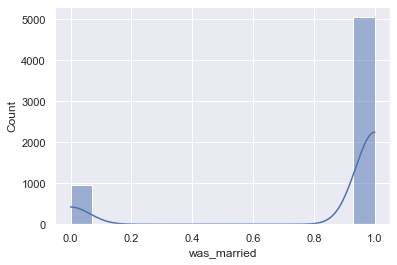

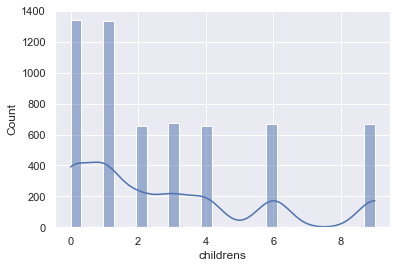

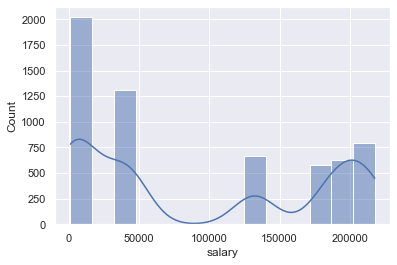

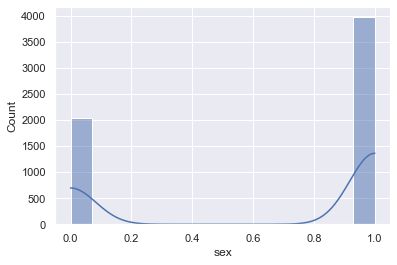

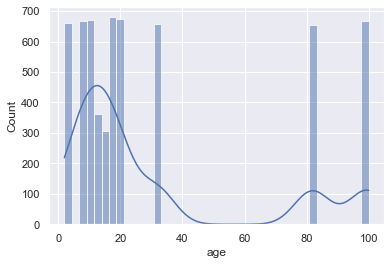

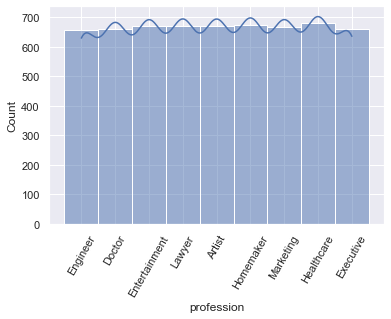

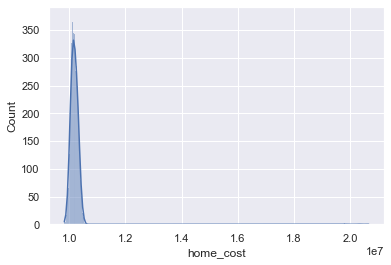

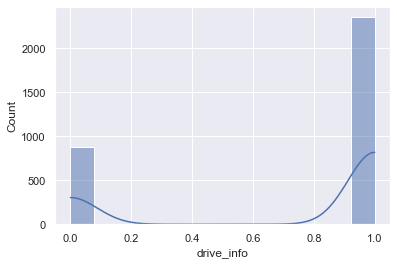

<Figure size 432x288 with 0 Axes>

In [7]:
from matplotlib.ticker import FixedLocator, FixedFormatter
signs = (sign for sign in df.columns.values)


for sign in signs:
    if sign == 'profession':
        # повернем ось х с названиями профессий для читабельности
        sns.histplot(df[sign], kde=True)
        ax = plt.gca()
        ax.tick_params(axis='x', labelrotation=60)
    else:
        sns.histplot(df[sign], kde=True)
    plt.figure()


Из всех графиков наиболее похожий на нормальное распределение имеет признак - home_cost

# Чистка датасета (5 баллов)
* Есть ли дубли в данных? 
* Есть ли пропуски в данных? 
* Как стоит поступить с выбросами? (удалить или заменить \ `dropna()` или `fillna()` )
* Удалить бесмысленные признаки (`drop()`)
* Найти и удалить выбросы по признаку `home_cost`. Сколько их?


<b>Дубли в данных</b>

Проверим наличие дублей в данных с помощью функции drop_duplicates и сравним с общим числом записей

In [8]:
total = len(df)
unique = len(df.drop_duplicates())

print(f'Total: {total}, without duplicates: {unique}, duplicates: {total != unique}')

# True - дубликаты имеются, False - дубликатов нет

Total: 6000, without duplicates: 5500, duplicates: True


Как видим, дубликаты в данных имеются

<b>Пропуски</b>

In [9]:
total = len(df)
drop_nan = len(df.dropna())
print(f'Total: {total}, without NaN: {drop_nan}')

# Посмотрим в каких столбцах есть пропуски

for column in df.columns:
    print(f'{column}: null is {round(np.mean(df[column].isnull()) * 100)}%')

Total: 6000, without NaN: 3230
id: null is 0%
was_married: null is 0%
childrens: null is 0%
salary: null is 0%
sex: null is 0%
age: null is 0%
profession: null is 0%
home_cost: null is 0%
drive_info: null is 46%


Как видим, пропуски имеются в столбце drive_info и составляют около 46%

<b>Выбросы</b>

<b>Удалить бессмысленные признаки</b>

Удалим признаки id и drive_info, т.к. id не несет смысловой нагрузки на отображение данных,
а в drive_info большой процент пропусков (46%), как видно из предыдущего расчета

In [10]:
new_df = df
new_df = new_df.drop(['id', 'drive_info'], axis=1)
print(f"Columns: {', '.join(new_df.columns.values)}")

Columns: was_married, childrens, salary, sex, age, profession, home_cost


<b>Найти и удалить выбросы home_cost</b>

Чтобы обнаружить выбросы, можно построить гистограмму или коробчатую диаграмму

<AxesSubplot:>

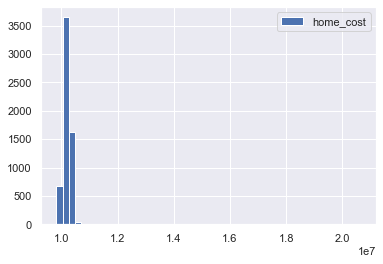

In [54]:
df['home_cost'].hist(bins=50, legend=True)

<AxesSubplot:>

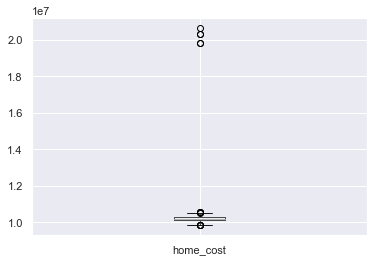

In [20]:
# для построения коробчатой диаграммы используем boxplot
df.boxplot(column=['home_cost'])

С помощью коробчатой диаграммы четко видим выбросы около значения 2.0 * 10^7.
Отбросим их, оставив только те, которые меньше 1.8 * 10^7:

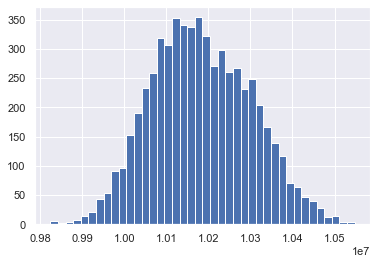

In [33]:
df[df['home_cost'] < 1.8 * 1e7]['home_cost'].hist(bins=40)

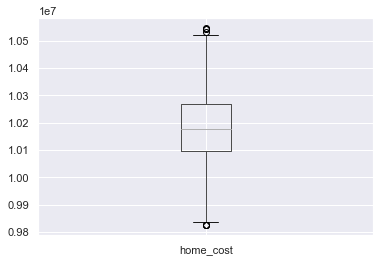

In [34]:
df[df['home_cost'] < 1.8 * 1e7].boxplot(column='home_cost')

In [35]:
print(f"Количество выбросов: {len(df[1.8 * 1e7 < df['home_cost']]['home_cost'])}")

Количество выбросов: 5


Картина значительно лучше, попробуем еще точнее

<AxesSubplot:>

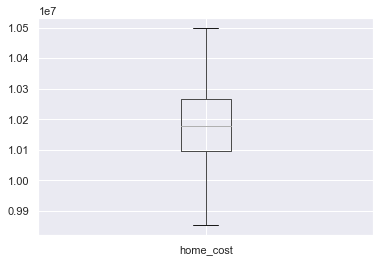

In [48]:
floor = .985 * 1e7
top = 1.05 * 1e7
df_hc = df[(floor < df['home_cost']) & (df['home_cost'] < top)]

df_hc.boxplot(column='home_cost')

<AxesSubplot:>

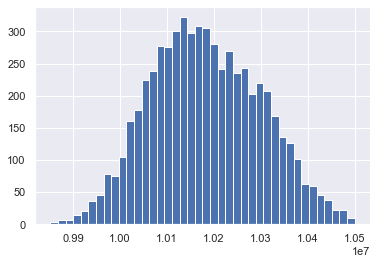

In [49]:
df_hc['home_cost'].hist(bins=40)

In [52]:
print(f"Количество выбросов: {len(df['home_cost']) - len(df_hc['home_cost'])}")


Количество выбросов: 28


Теперь гистограмма колонки home_cost имеет нормальное распределение

# Изучение зависимых признаков (5 балла). 
* Построить матрицу корреляций
* Визуализировать матрицу корреляции с помощью heatmap
* Сделать выводы по самым скоррелированные признакам
* Построить график зависимости между двумя самыми зависимыми признаками


<b>Построить матрицы корелляций</b>
Для этого используется метод corr(), построим матрицу для численных признаков

In [59]:
df.corr()
num_df = new_df.select_dtypes(include=('int', 'float'))
corr_matrix = num_df.corr()
corr_matrix
# по дефолту используется метод Пирсона

,was_married,childrens,salary,sex,age,home_cost
was_married,1.000000,0.242263,-0.499884,0.337497,0.200650,-0.118290
childrens,0.242263,1.000000,0.395872,0.388888,0.743052,0.097098
salary,-0.499884,0.395872,1.000000,0.248348,0.078350,0.249784
sex,0.337497,0.388888,0.248348,1.000000,0.341431,0.077643
age,0.200650,0.743052,0.078350,0.341431,1.000000,0.013599
home_cost,-0.118290,0.097098,0.249784,0.077643,0.013599,1.000000


<b>Визуализация матрицы корреляции<b/>

<AxesSubplot:>

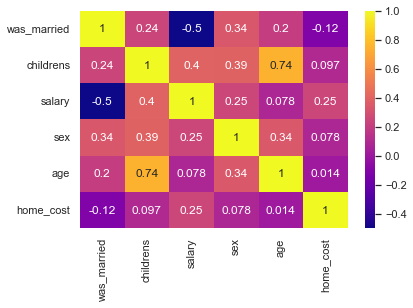

In [62]:
sns.heatmap(corr_matrix, annot=True, cmap='plasma')

<b>Сделать выводы о корреляции<b/>
Самыми скоррелированными признаками, исходя из матрицы, являются children и age,
попадают в группу 0.5-0.74 (высокая положительная)

<b>График зависимости</b>

<Figure size 720x720 with 0 Axes>

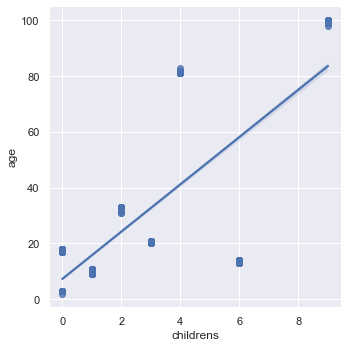

<Figure size 720x720 with 0 Axes>

In [64]:
sns.lmplot(data=num_df, x='childrens', y='age')
plt.figure(figsize=(10, 10))

# Нормировка признаков (3 балла)
* Отнормировать данные
* Обосновать выбор нормировки

In [14]:
# Вспомогательные код

# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 


# normal_data = 'Ваш код' #

# Выделить кластеры (6 баллов)
* Определить оптимальное количество кластеров с помощью правила локтя/осыпи
* Получить номера класстеров для каждого пользователя. 

In [15]:
# Вспомогательные код

# from sklearn.cluster import KMeans

# clusterer = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
# cluster_labels = clusterer.fit_predict(data)

# Снизить разерность (6 баллов)

Воспользуйтесь методом `t-SNE ()` (или `PCA`, `U-MAP`)

ссылка на документацию:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [16]:
# Вспомогательные код

# from sklearn.manifold import TSNE

# data_x_y = TSNE(n_components=2, learning_rate='auto',
#                 random_state=22, n_jobs=-1, 
#                 init='random').fit_transform(df)

# Нарисовать полученные кластеры (10 баллов)

In [17]:
# Вспомогательные код

# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,9))
# plt.scatter(data_x, data_y, c=cluster_labels, cmap ='Set3', s=5)
# plt.scatter(data_x, data_y, c=y_blobs, s=1, cmap ='Set3')
# # plt.legend(cluster_labels)
# plt.show()

# Дополнительные баллы (+10 баллов)
* Аккуратный и понятный код **+5 баллов**
* Присутствуют лаконичные и понятные комментарии **+5 балов**